If you read in an image using matplotlib.image.imread() you will get an RGB image, but if you read it in using OpenCV cv2.imread() this will give you a BGR image. 

hls = cv2.cvtColor(im, cv2.COLOR_RGB2HLS) 



In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import glob
import math
from skimage.feature import corner_harris,corner_peaks
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib qt
%matplotlib inline


## Perform camera calibration 


In [5]:

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        
        #cv2.imshow('img', img)
        #cv2.waitKey(500)

cv2.destroyAllWindows()


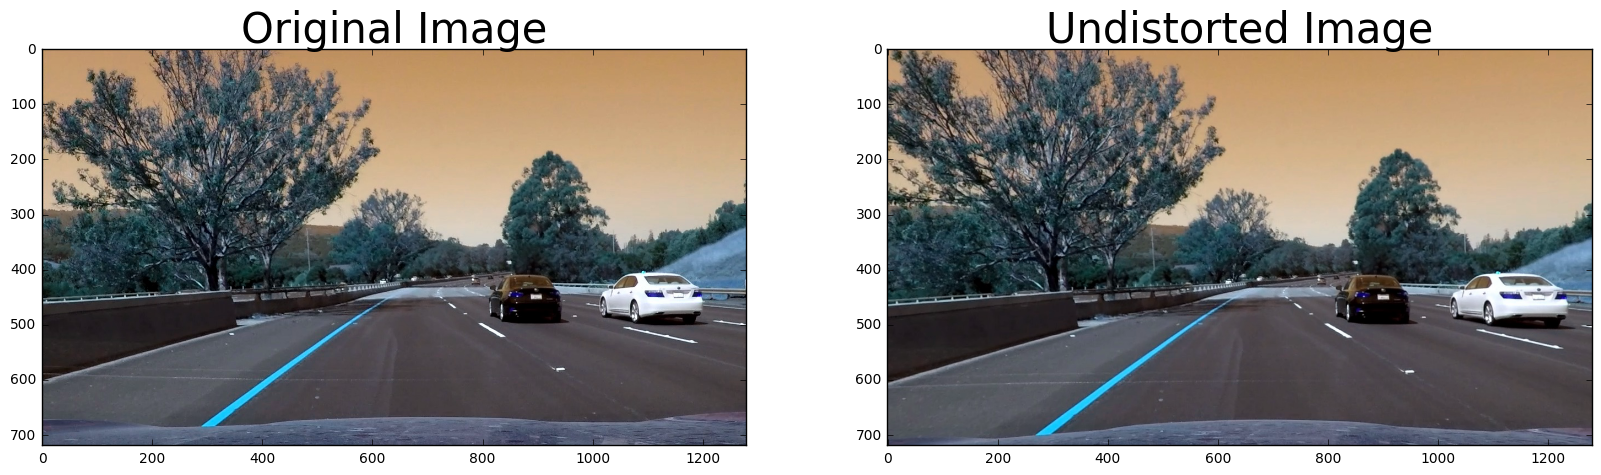

In [7]:
#Implement calibration on the images that will be used

import pickle
 

# Test undistortion on an image
img = cv2.imread('test_images/Distorted/test6.jpg')
img_size = (img.shape[1], img.shape[0])
#img = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
#dst = cv2.cvtColor(dst, cv2.COLOR_RGB2BGR)
cv2.imwrite('test_images/test6.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
#dist_pickle = {}
#dist_pickle["mtx"] = mtx
#dist_pickle["dist"] = dist
#pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Image preprocessing and filtering

In [8]:
#Methods

def draw_lines(img, lines, color=[255, 0, 0], thickness=12):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #Filter, Average and extrapolate lines to the top and bottom of the lane area 
    num_row=img.shape[0]
    lines = line_extrapolation(lines, num_row) # get the line return value of x1,x2,y1,y2 and a tuple od the number or rows using (.shape)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros(list(img.shape) + [3], dtype=np.uint8)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def gaussian_noise(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255   
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def transform(img):
    imshape = img.shape
    img_size = (img.shape[1], img.shape[0])
    src=np.float32([[160,imshape[0]],[imshape[1]/2-60, imshape[0]/2+90],[imshape[1]/2+100, imshape[0]/2+90], [imshape[1]-20,imshape[0]]])
    dst=np.float32([[(240,imshape[0]),(240, 0),(imshape[1]-130, 0), (imshape[1]-130,imshape[0])]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    wraped =  cv2.warpPerspective(img,M,img_size, flags=cv2.INTER_LINEAR)
    
    return  Minv, wraped


(720, 1280, 3)


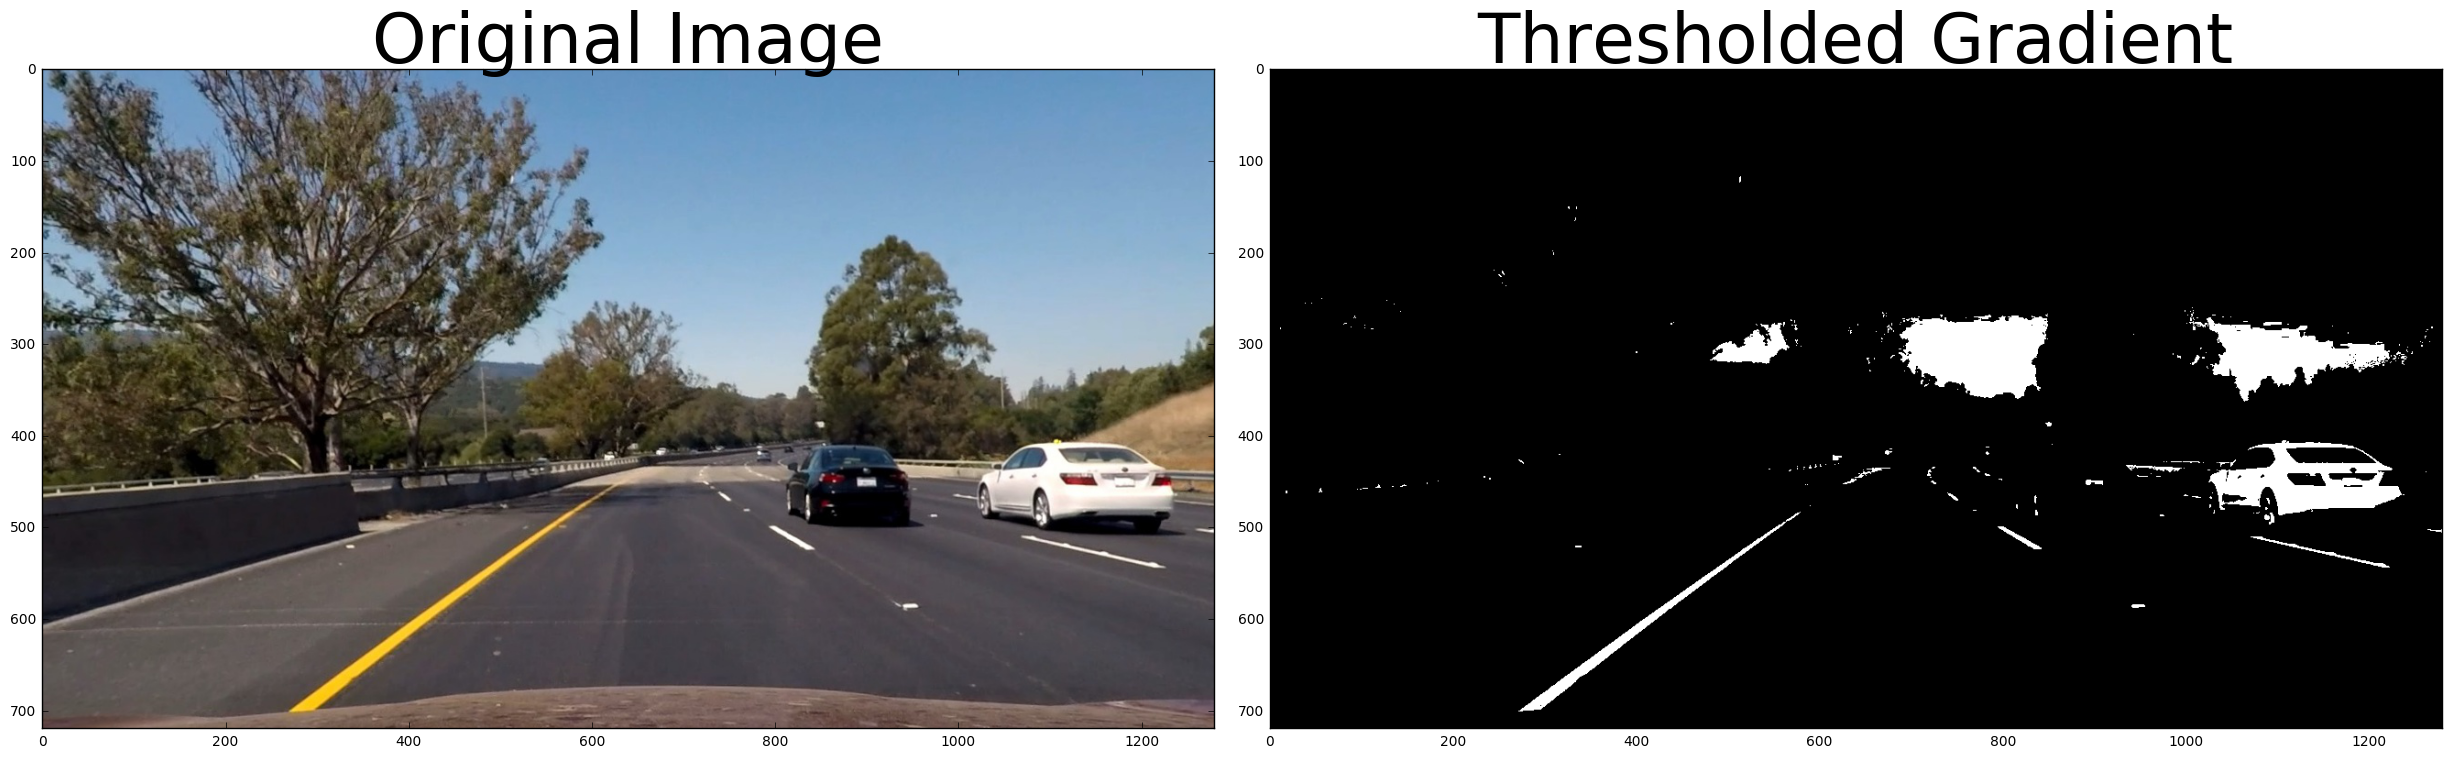

In [9]:
#Read in the image
image = mpimg.imread('test_images/test6.jpg')
#Blur the image
blur_kernel_size = 1
image = gaussian_noise(image, blur_kernel_size)

#Define a mask but only implement it after edge detection dot not be detected
imshape = image.shape
        #vertices = np.array([[(80,imshape[0]),(400, 330), (580, 330), (imshape[1],imshape[0])]], dtype=np.int32)
vertices = np.array([[(160,imshape[0]),(imshape[1]/2-60, imshape[0]/2+90),
                  (imshape[1]/2+100, imshape[0]/2+90), (imshape[1]-20,imshape[0])]], dtype=np.int32)
vertices = np.array([[(160,imshape[0]),(imshape[1]/2-60, imshape[0]/2+90),
                  (imshape[1]/2+100, imshape[0]/2+90), (imshape[1]-20,imshape[0])]], dtype=np.int32)
#image = region_of_interest(image, vertices)
 



thresh = (190, 255)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)



binary = np.zeros_like(gray)
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

print(imshape)

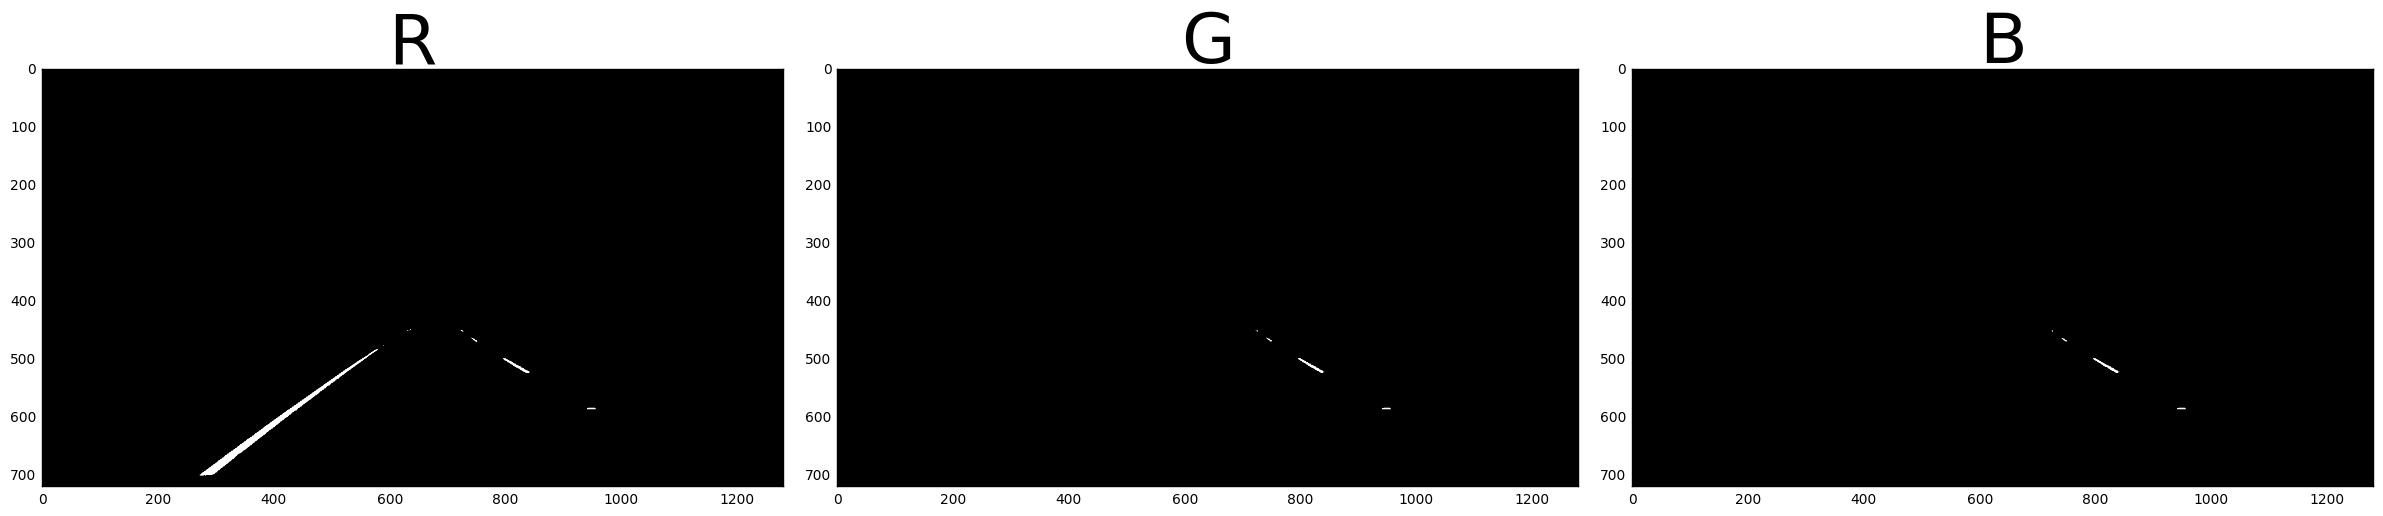

In [10]:
# Splitting RGB Channels
R = image[:,:,0]
G = image[:,:,1]
B = image[:,:,2]
thresh = (220, 255)
#gray_ = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
binary_R = np.zeros_like(R)
binary_R[(R > thresh[0]) & (R <= thresh[1])] = 1
binary_R= region_of_interest(binary_R, vertices)

binary_G = np.zeros_like(G)
binary_G[(G > thresh[0]) & (G <= thresh[1])] = 1
binary_G= region_of_interest(binary_G, vertices)

binary_B = np.zeros_like(B)
binary_B[(B > thresh[0]) & (B <= thresh[1])] = 1
binary_B= region_of_interest(binary_B, vertices)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binary_R, cmap='gray')
ax1.set_title('R', fontsize=50)
ax2.imshow(binary_G, cmap='gray')
ax2.set_title('G', fontsize=50)
ax3.imshow(binary_B, cmap='gray')
ax3.set_title('B', fontsize=50)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [11]:
'''
# Splitting HSV Channels
HSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

H = HSV[:,:,0]
S = HSV[:,:,1]
V = HSV[:,:,2]
thresh = (100, 255)
#gray_ = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
binary_H = np.zeros_like(H)
binary_H[(H > thresh[0]) & (H <= thresh[1])] = 1

binary_S = np.zeros_like(S)
binary_S[(S > thresh[0]) & (S <= thresh[1])] = 1

binary_V = np.zeros_like(V)
binary_V[(V > thresh[0]) & (V <= thresh[1])] = 1

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binary_H, cmap='gray')
ax1.set_title('H', fontsize=50)
ax2.imshow(binary_S, cmap='gray')
ax2.set_title('S', fontsize=50)
ax3.imshow(binary_V, cmap='gray')
ax3.set_title('V', fontsize=50)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

'''

"\n# Splitting HSV Channels\nHSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)\n\nH = HSV[:,:,0]\nS = HSV[:,:,1]\nV = HSV[:,:,2]\nthresh = (100, 255)\n#gray_ = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)\nbinary_H = np.zeros_like(H)\nbinary_H[(H > thresh[0]) & (H <= thresh[1])] = 1\n\nbinary_S = np.zeros_like(S)\nbinary_S[(S > thresh[0]) & (S <= thresh[1])] = 1\n\nbinary_V = np.zeros_like(V)\nbinary_V[(V > thresh[0]) & (V <= thresh[1])] = 1\n\nf, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))\nf.tight_layout()\nax1.imshow(binary_H, cmap='gray')\nax1.set_title('H', fontsize=50)\nax2.imshow(binary_S, cmap='gray')\nax2.set_title('S', fontsize=50)\nax3.imshow(binary_V, cmap='gray')\nax3.set_title('V', fontsize=50)\n#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)\n\n"

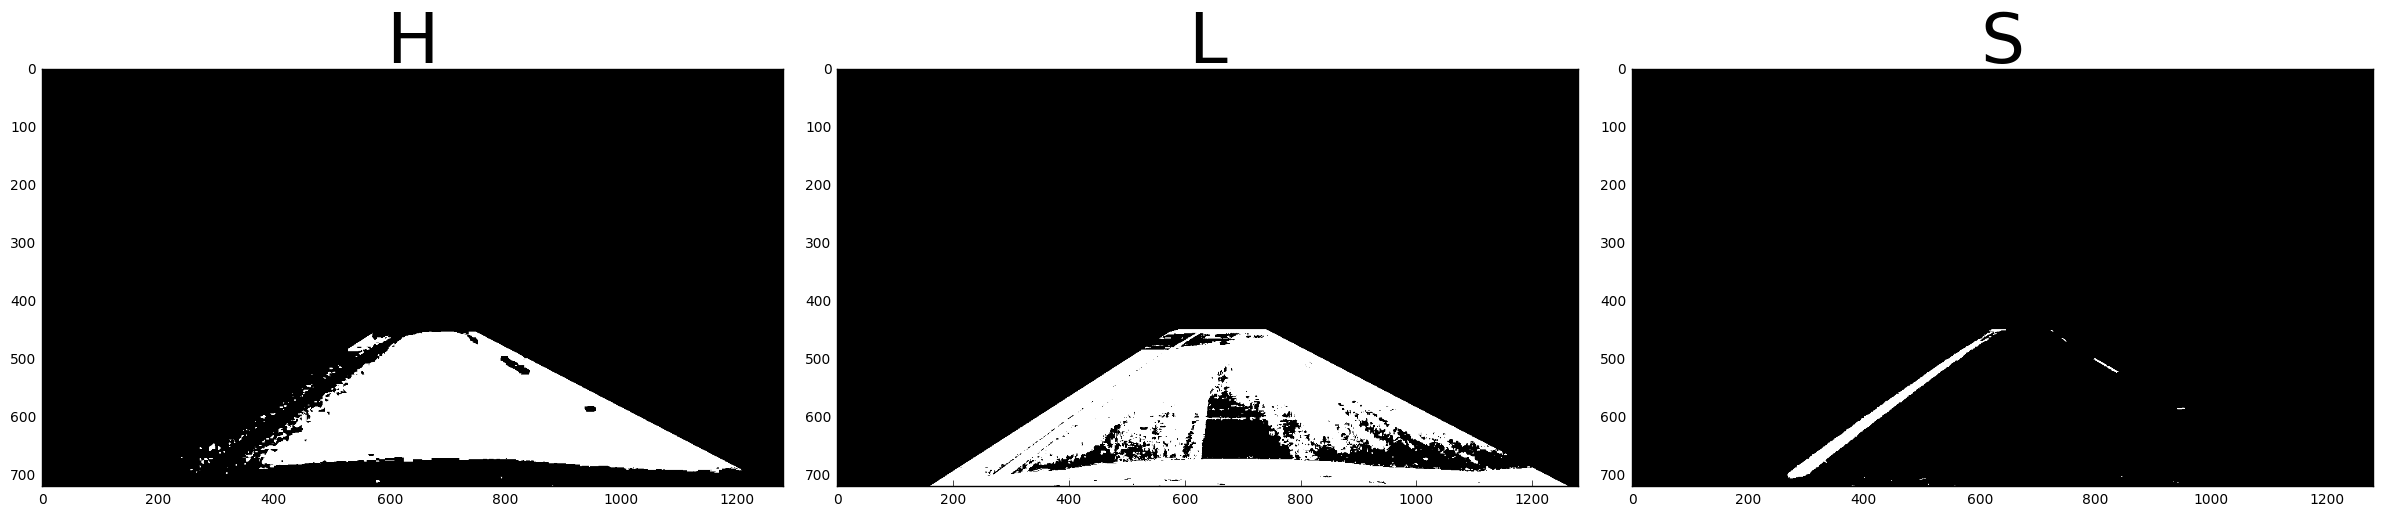

In [12]:
# Splitting HSV Channels
HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

H = HLS[:,:,0]
L = HLS[:,:,1]
S = HLS[:,:,2]
thresh = (70, 255)
#gray_ = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
binary_H = np.zeros_like(H)
binary_H[(H > thresh[0]) & (H <= thresh[1])] = 1
binary_H= region_of_interest(binary_H, vertices)

binary_L = np.zeros_like(L)
binary_L[(L > thresh[0]) & (L <= thresh[1])] = 1
binary_L= region_of_interest(binary_L, vertices)

binary_S = np.zeros_like(S)
binary_S[(S > thresh[0]) & (S <= thresh[1])] = 1
binary_S= region_of_interest(binary_S, vertices)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binary_H, cmap='gray')
ax1.set_title('H', fontsize=50)
ax2.imshow(binary_L, cmap='gray')
ax2.set_title('L', fontsize=50)
ax3.imshow(binary_S, cmap='gray')
ax3.set_title('S', fontsize=50)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

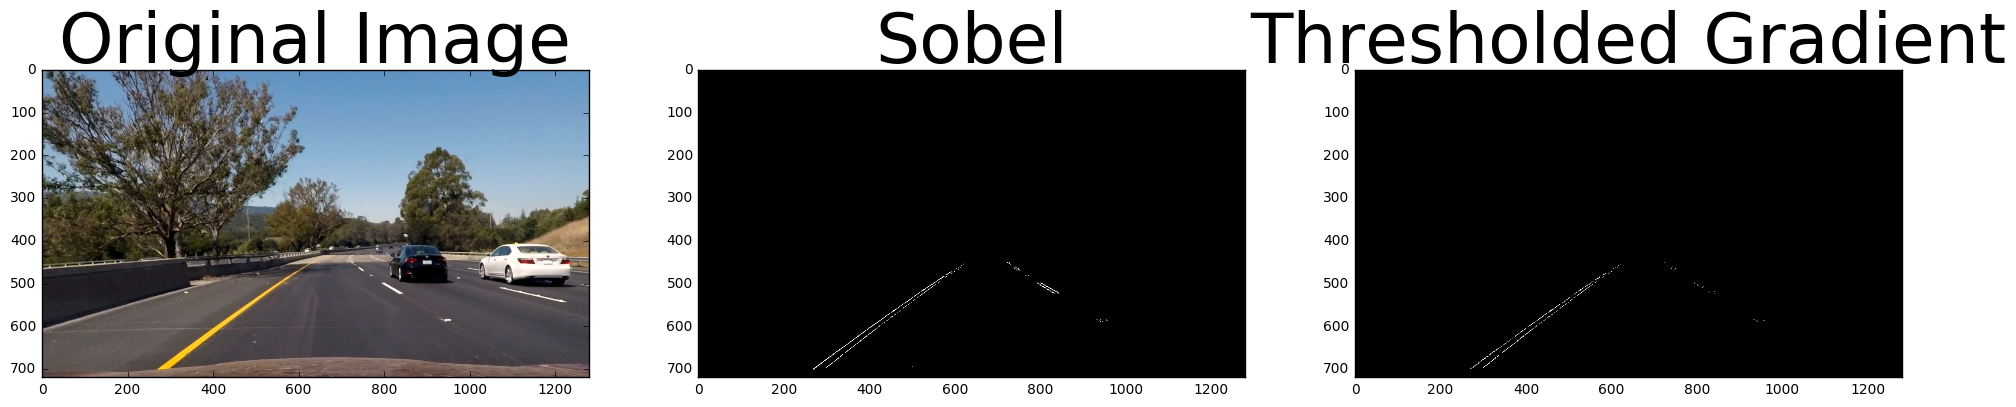

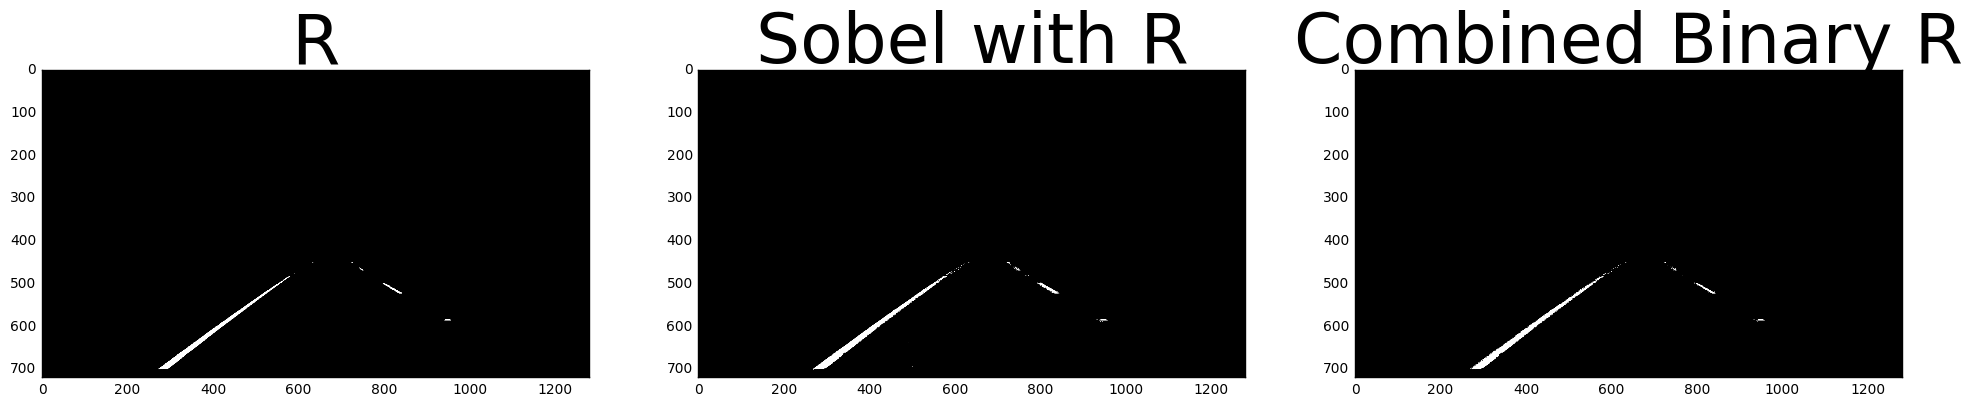

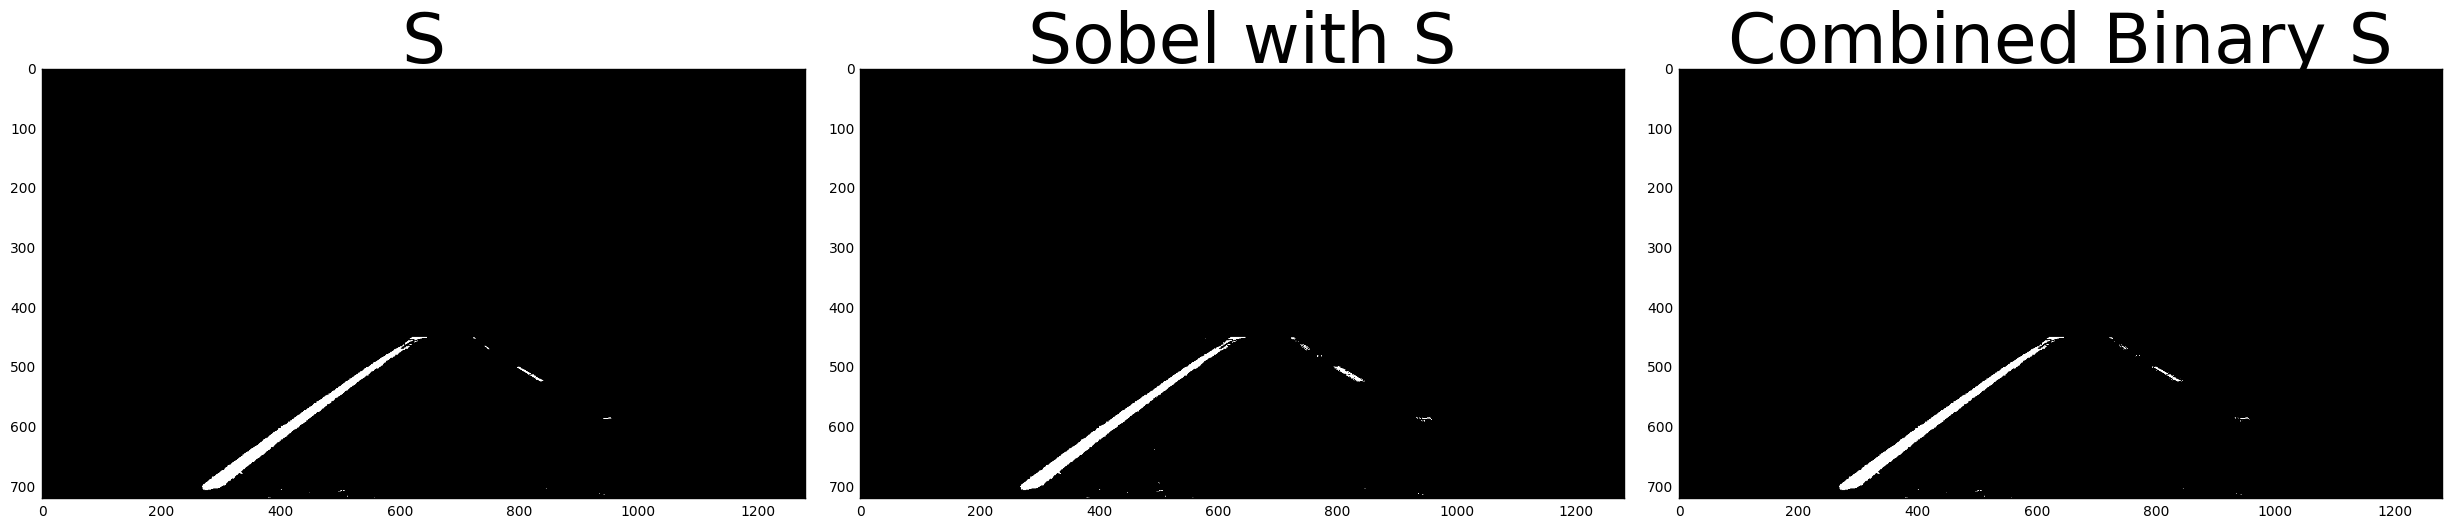

In [13]:
#hough line detection
rho = 2
theta = np.pi/180
threshold = 60
min_line_len = 30
max_line_gap = 30



# Read in an image and grayscale it
 
## return sobel threshold
def abs_sobel_thresh(img, orient, sobel_kernel, thresh):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    #binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

## return mag_direction

def mag_thresh(img, sobel_kernel, mag_thresh):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

## return the gradient

def dir_threshold(img, sobel_kernel, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx=np.absolute(sobelx)
    abs_sobely=np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dir_grad)
    binary_output[(dir_grad >= thresh[0]) & (dir_grad <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output

ksize=3

gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(50, 100))
gradx = region_of_interest(gradx, vertices)
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(50, 100))
grady = region_of_interest(grady, vertices)
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
mag_binary = region_of_interest(mag_binary, vertices)
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.3, 1.5)) 
dir_binary = region_of_interest(dir_binary, vertices)

#dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1


#Combine all combined binary and R channel

combined_binary_R = np.zeros_like(combined )
combined_binary_R[(binary_R== 1) | (combined == 1)] = 1

#color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
#Combine all combined binary and S channel

combined_binary_S = np.zeros_like(combined )
combined_binary_S[(binary_S== 1) | (combined == 1)] = 1

#Combine Sobel and R channel

Sobel_binary_R = np.zeros_like(gradx)
Sobel_binary_R[(binary_R== 1) | (gradx== 1)] = 1

#Combine all combined binary and S channel

Sobel_binary_S = np.zeros_like(gradx )
Sobel_binary_S[(binary_S== 1) | (gradx == 1)] = 1

#Sobel_binary_S = hough_lines(Sobel_binary_S, rho, theta, threshold, min_line_len, max_line_gap)


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(24, 9))
f, (ax7, ax8, ax9) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
 
#####
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(gradx, cmap='gray')
ax2.set_title('Sobel', fontsize=50)
ax3.imshow(combined, cmap='gray')
ax3.set_title('Thresholded Gradient', fontsize=50)
#####
#####
ax4.imshow(binary_R, cmap='gray')
ax4.set_title('R', fontsize=50)
ax5.imshow(Sobel_binary_R , cmap='gray')
ax5.set_title('Sobel with R', fontsize=50)
ax6.imshow(combined_binary_R, cmap='gray')
ax6.set_title('Combined Binary R', fontsize=50)
#####
#####
ax7.imshow(binary_S, cmap='gray')
ax7.set_title('S', fontsize=50)
ax8.imshow(Sobel_binary_S , cmap='gray')
ax8.set_title('Sobel with S', fontsize=50)
ax9.imshow(combined_binary_S, cmap='gray')
ax9.set_title('Combined Binary S', fontsize=50)
#####
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Perspective transform

 

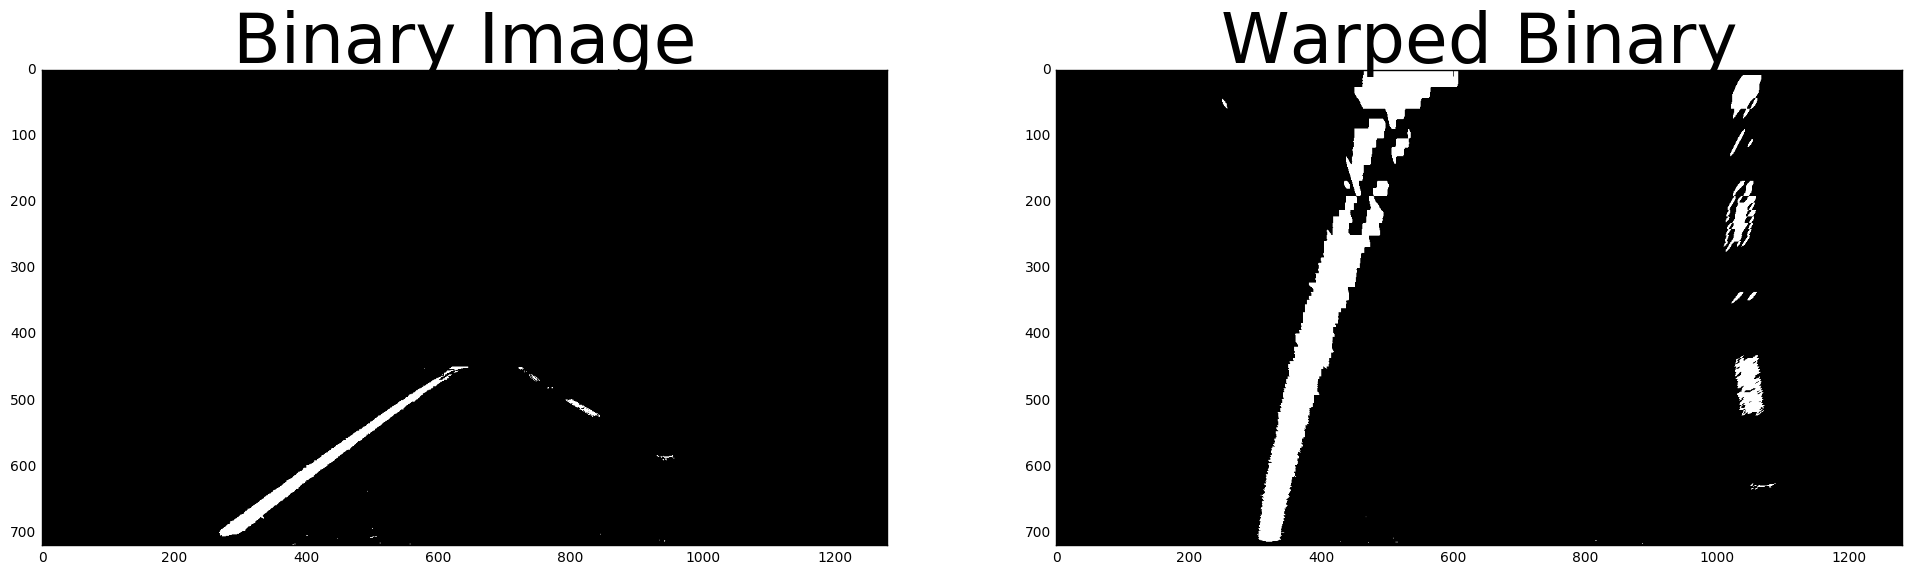

In [14]:
 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
Minv, warped_img= transform(Sobel_binary_S)

ax1.imshow(Sobel_binary_S, cmap='gray')
ax1.set_title('Binary Image', fontsize=50)
ax2.imshow(warped_img, cmap='gray')
ax2.set_title('Warped Binary', fontsize=50)
 
 

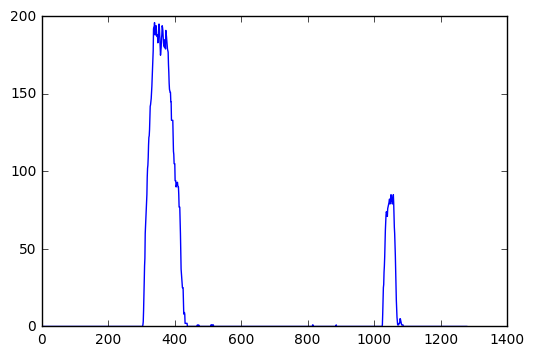

In [15]:
# Locate the Lane Lines and Determine the Curvature

#first take a histogram along all the columns in the lower half of the image like this:
histogram = np.sum(warped_img[warped_img.shape[0]/2:,:], axis=0)
plt.plot(histogram)



In [29]:

# sample histogram of the bottom 40% pixels from a black & white image bw_image
'''
bw_img=warped_img
histogram = np.sum(bw_img[np.int(bw_img.shape[0]*0.6):,:], axis=0)

def lane_centers(h):
    # h is a histogram of lane pixels
    # find the left and right max, which we return
    # as lane centers
    midpoint = np.int(h.shape[0]/2)
    mark_left = np.argmax(h[0:midpoint])
    mark_right = np.argmax(h[midpoint:])+midpoint
    return mark_left, mark_right

def copy_sliding_y_window(src, dst, mid, win_size=80):
    # src contains pixels of potential lane markers
    # dst is an empty image that will receive candidate pixels
    # by sliding a window from "mid"-point, the vertical y coordinate
    # for a potential lane marker.
    for row in range(src.shape[0]-1,0,-1):
        lo = max(0,mid-win_size)
        hi = min(mid+win_size, src.shape[1]-1)
        scan_line = src[row,lo:hi]
        dst[row,lo:hi] = scan_line
        ones = np.where(scan_line == 1)
        if len(ones[0]):
            mid = np.int(np.mean(ones)+lo+0.5)

ml, mr = lane_centers(histogram)
lines = np.zeros_like(bw_img)
copy_sliding_y_window(bw_img, lines, ml)
copy_sliding_y_window(bw_img, lines, mr)
plt.axis('off')
plt.imshow(lines, cmap='gray')
'''

'\nbw_img=warped_img\nhistogram = np.sum(bw_img[np.int(bw_img.shape[0]*0.6):,:], axis=0)\n\ndef lane_centers(h):\n    # h is a histogram of lane pixels\n    # find the left and right max, which we return\n    # as lane centers\n    midpoint = np.int(h.shape[0]/2)\n    mark_left = np.argmax(h[0:midpoint])\n    mark_right = np.argmax(h[midpoint:])+midpoint\n    return mark_left, mark_right\n\ndef copy_sliding_y_window(src, dst, mid, win_size=80):\n    # src contains pixels of potential lane markers\n    # dst is an empty image that will receive candidate pixels\n    # by sliding a window from "mid"-point, the vertical y coordinate\n    # for a potential lane marker.\n    for row in range(src.shape[0]-1,0,-1):\n        lo = max(0,mid-win_size)\n        hi = min(mid+win_size, src.shape[1]-1)\n        scan_line = src[row,lo:hi]\n        dst[row,lo:hi] = scan_line\n        ones = np.where(scan_line == 1)\n        if len(ones[0]):\n            mid = np.int(np.mean(ones)+lo+0.5)\n\nml, mr = la

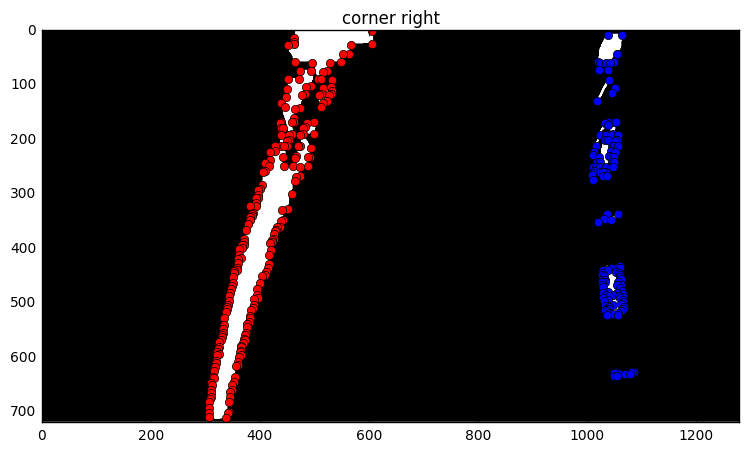

Number of left corners: 215 Number of right corners: 133


In [30]:

## define the left and right lane 
#Find the corners in the image and find their x and y coordinates. 

# More pyplot!
warped_img = lines

row_w,col_w=warped_img.shape

warped_img_left=warped_img[0:row_w,0:math.ceil(col_w/2)]
warped_img_right=warped_img[0:row_w,math.ceil(col_w/2):col_w]
def show_corners(corners_l, corners_r,image,title=None):
    """Display a list of corners overlapping an image"""
    fig = plt.figure()
    plt.imshow(image,cmap='gray')
 
    y_corner_l,x_corner_l = zip(*corners_l)
    
    y_corner_r,x_corner_r = zip(*corners_r)
   
    plt.plot(x_corner_l,y_corner_l,'ro') # Plot corners
    plt.plot(x_corner_r,y_corner_r,'bo') # Plot corners
 
    if title:
        plt.title(title)
    plt.xlim(0,image.shape[1])
    plt.ylim(image.shape[0],0) # Images use weird axes
    fig.set_size_inches(np.array(fig.get_size_inches()) * 1.5)
    plt.show()
    print ("Number of left corners:",len(corners_l),"Number of right corners:",len(corners_r), )    
 
corners_left = corner_peaks(corner_harris(warped_img_left),min_distance=2)
corners_right = corner_peaks(corner_harris(warped_img_right),min_distance=2)

show_corners(corners_left,corners_right+[0,math.ceil(col_w/2)],warped_img,title="corner right")    


    
 

In [31]:
y_corner_l,x_corner_l = zip(*corners_left)

adjusted_corners_right= corners_right+[0,math.ceil(col_w/2)]
                                      
y_corner_r,x_corner_r = zip(*adjusted_corners_right)

2799.24153227 2573.65775103
1693.73473374 m 1838.62466671 m


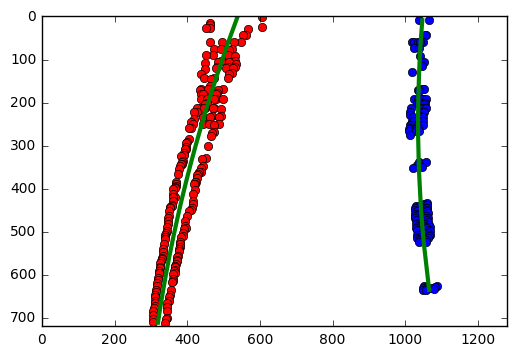

In [21]:
#Measuring Curvature
yvalus = warped_img.shape[0]
 
# Generate some fake data to represent lane-line pixels
yvals = np.linspace(0, 100, num=101)*(yvalus/100.0)  # to cover same y-range as image

#leftx = np.array([200 + (elem**2)*4e-4 + np.random.randint(-50, high=51) 
                              #for idx, elem in enumerate(yvals)])
#leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
leftx = np.array(x_corner_l)
lefty = np.array(y_corner_l)

#rightx = np.array([900 + (elem**2)*4e-4 + np.random.randint(-50, high=51) 
                                #for idx, elem in enumerate(yvals)])
#rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
rightx = np.array(x_corner_r)
righty = np.array(y_corner_r)
# Fit a second order polynomial to each fake lane line

left_fit = np.polyfit(lefty, leftx, 2)




left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]

right_fit = np.polyfit(righty, rightx, 2)
right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]

# Plot up the fake data
plt.plot(leftx, lefty, 'o', color='red')
plt.plot(rightx, righty, 'o', color='blue')
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, lefty, color='green', linewidth=3)
plt.plot(right_fitx, righty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval_l = np.max(700)
y_eval_r = np.max(700)
left_curverad = ((1 + (2*left_fit[0]*y_eval_l + left_fit[1])**2)**1.5) \
                             /np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval_r + right_fit[1])**2)**1.5) \
                                /np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1163.9    1213.7

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meteres per pixel in x dimension

left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval_l + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval_r + right_fit_cr[1])**2)**1.5) \
                                /np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 3380.7 m    3189.3 m
                   

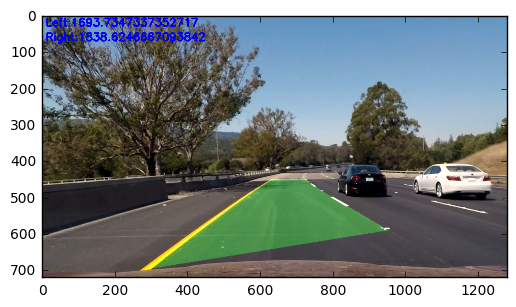

In [28]:
#Drawing the lines back down onto the road
#mage called warped, and you have fit the lines with a polynomial and have arrays called yvals, 
#left_fitx and right_fitx,

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped_img).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, lefty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, righty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
final_result=cv2.putText(result, "Left:{}".format(left_curverad),(10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 3)
final_result=cv2.putText(result, "Right:{}".format(right_curverad),(10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 3)
plt.imshow(final_result)

In [ ]:
white_output = 'output_easy.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipe_line) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))